# Imports

In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

# Constants

In [3]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

# Data

In [4]:
data_births = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'daily-total-female-births-CA.csv',
    index_col=['date'],
    parse_dates=['date']
)

# Autoregressive Models

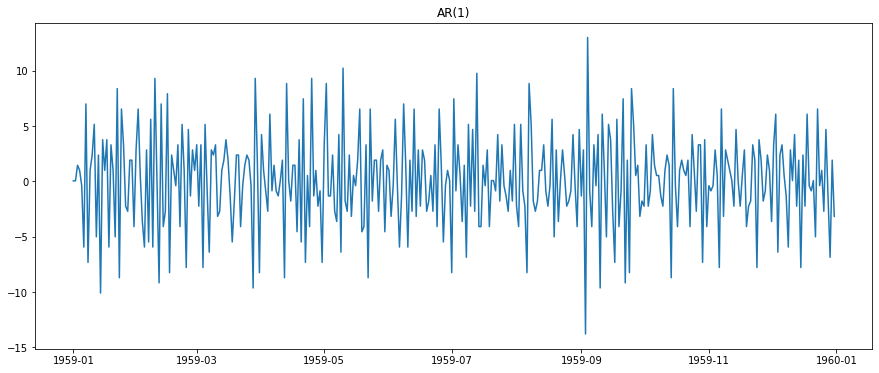

In [5]:
model_ar1 = pm.ARIMA(order=(1, 0, 0))
model_ar1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar1.predict_in_sample())
plt.title('AR(1)')
plt.show()

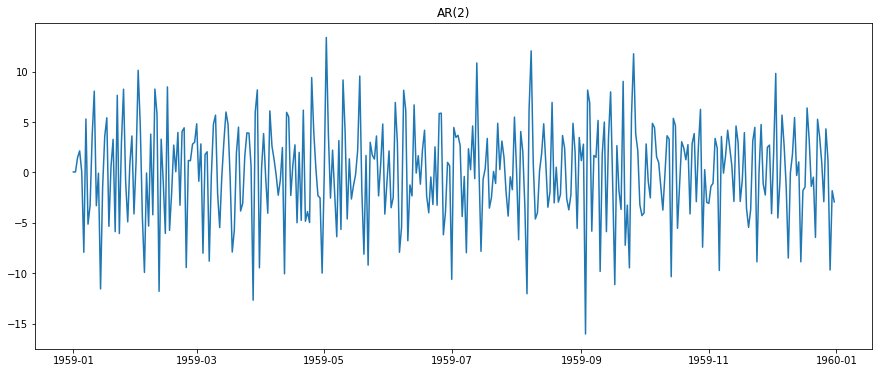

In [6]:
model_ar2 = pm.ARIMA(order=(2, 0, 0))
model_ar2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar2.predict_in_sample())
plt.title('AR(2)')
plt.show()

# Moving Average

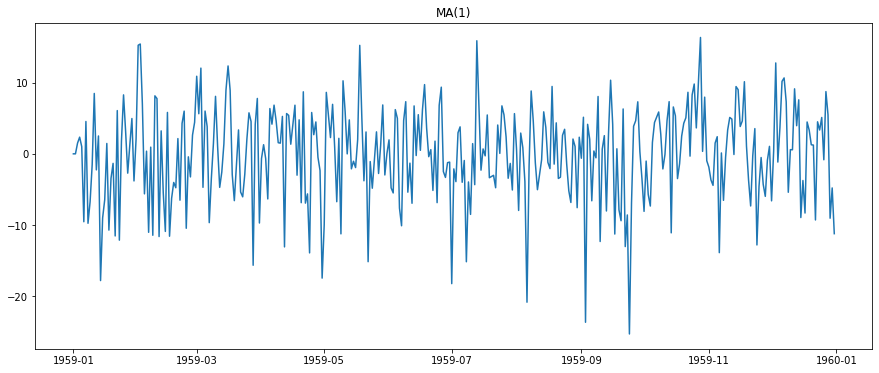

In [7]:
model_ma1 = pm.ARIMA(order=(0, 0, 1))
model_ma1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma1.predict_in_sample())
plt.title('MA(1)')
plt.show()

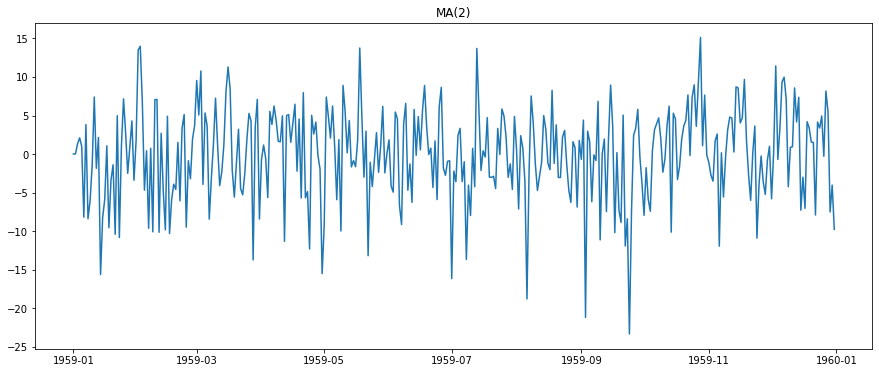

In [8]:
model_ma2 = pm.ARIMA(order=(0, 0, 2))
model_ma2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma2.predict_in_sample())
plt.title('MA(2)')
plt.show()

# Autocorrelation and Partial Autocorrelation Functions

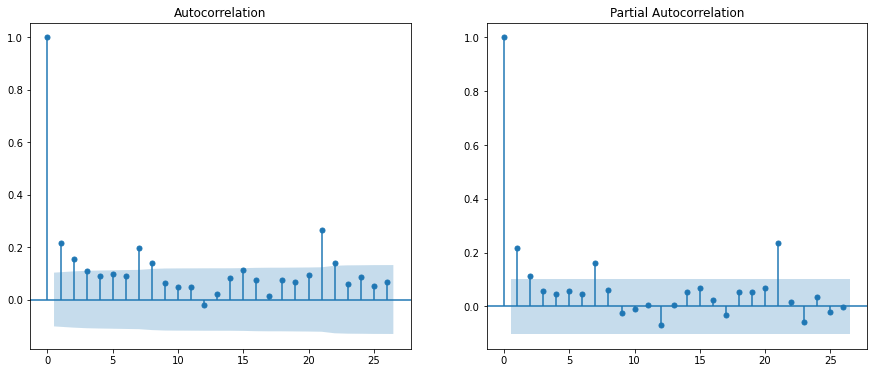

In [5]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.utils.plot_acf(data_births['births'], alpha=0.05, ax=ax1, show=False)
pm.utils.plot_pacf(data_births['births'], alpha=0.05, ax=ax2, show=False)
plt.show()

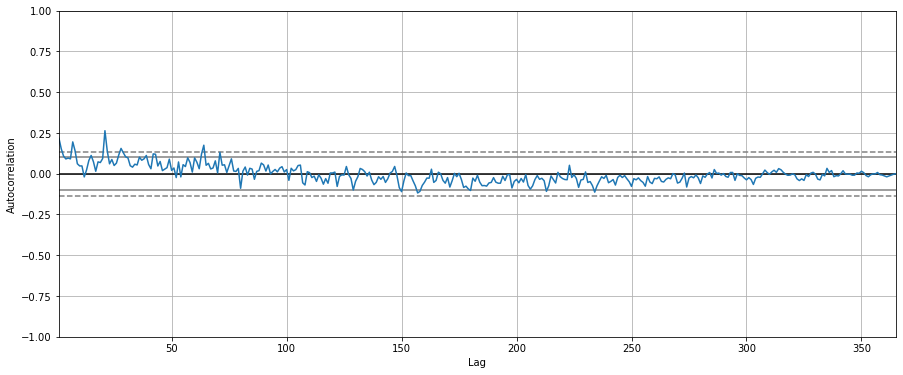

In [6]:
plt.figure(figsize=(15, 6))
pm.utils.autocorr_plot(data_births['births'])